# Fundamentals of ML

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from plot_utils import plot_history
%matplotlib inline

print(f"{tf.__version__ = }")

tf.__version__ = '2.6.1'


## Spurious correlations

Lets train on mnist twice, once adding random noise, once adding zeros

In [2]:
from tensorflow.keras.datasets import mnist

# load
(train_images, train_labels), _ = mnist.load_data()

# simple prep
train_images = train_images.reshape((-1, 28 * 28)).astype("float32") / 255
print(f"{train_images.shape = }")

train_images.shape = (60000, 784)


In [3]:
noise = np.random.random((len(train_images), 784))
zeros = np.zeros_like(noise)

train_images_w_zeros = np.concatenate((train_images, zeros), axis=1)
train_images_w_noise = np.concatenate((train_images, noise), axis=1)

print(f"{train_images_w_zeros.shape = }")
print(f"{train_images_w_noise.shape = }")

train_images_w_zeros.shape = (60000, 1568)
train_images_w_noise.shape = (60000, 1568)


In [4]:
def get_model():
    model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

In [5]:
model = get_model()
history_noise = model.fit(train_images_w_noise, train_labels, epochs=30, batch_size=128, validation_split=.2, verbose=0)

model = get_model()
history_zeros = model.fit(train_images_w_zeros, train_labels, epochs=30, batch_size=128, validation_split=.2, verbose=0)

2022-04-15 17:05:15.607670: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-15 17:05:16.161953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10801 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7
2022-04-15 17:05:16.942039: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


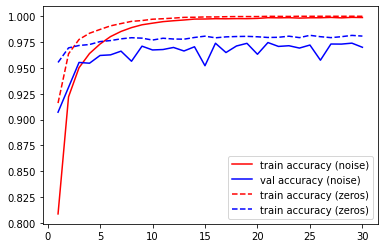

In [6]:
plt.figure()
epoch_range = range(1, 31)

plt.plot(epoch_range, history_noise.history['accuracy'], 'r-', label="train accuracy (noise)")
plt.plot(epoch_range, history_noise.history['val_accuracy'], 'b-', label="val accuracy (noise)")
plt.plot(epoch_range, history_zeros.history['accuracy'], 'r--', label="train accuracy (zeros)")
plt.plot(epoch_range, history_zeros.history['val_accuracy'], 'b--', label="train accuracy (zeros)")

plt.legend()
plt.show()

## Fiting a model on random data

In [7]:
random_labels = train_labels.copy() # not random yet
np.random.shuffle(random_labels) # now they are random

model = get_model()

random_history = model.fit(train_images, random_labels, epochs=100, batch_size=128, validation_split=.2, verbose=0)

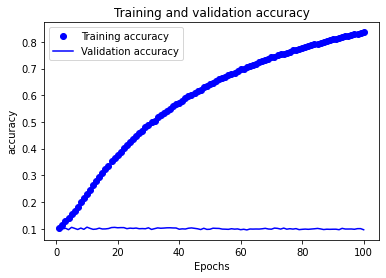

In [8]:
plot_history(random_history, "accuracy")

# Improving model fit

There are 3 common problems you'll encounter when training a model:
1. Training loss doesn't go down
2. Training loss goes down, but the model doesn't generalize
3. Training and validation losses go down, but you don't seem to be able to overfit

## Tunning key gradient descent parameters

For situation *1.*.

Remember a DL model can fit anything*. You should always be able to overcome this. *1.* is always a problem with the configurtion of the gradient descent process.
- optimizer
- initialization of weights
- learning rate
- batch size

It's usually enough to tune *lr* and *bs*.

In [9]:
# lets train the model from chapter 2 with an inappropriately large lr

(train_images, train_labels), _ = mnist.load_data()

train_images = train_images.reshape((60_000, 28*28))
train_images = train_images.astype("float32") / 255

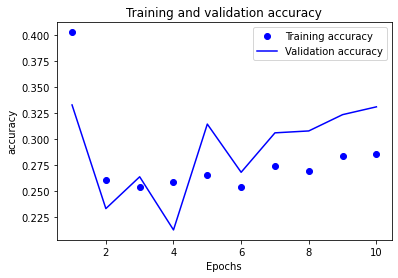

In [10]:
def get_model(lr: float):
    model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=keras.optimizers.RMSprop(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


model = get_model(lr=1.) # very big lr

lr_too_big_history = model.fit(
    train_images, 
    train_labels, 
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=0,
    )

plot_history(lr_too_big_history, "accuracy")

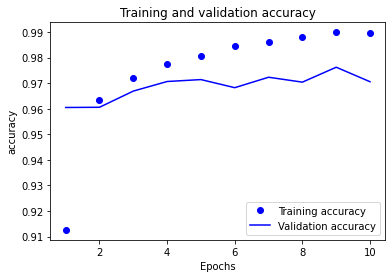

In [11]:
model = get_model(lr=1e-2) #better lr

better_lr_history = model.fit(
    train_images, 
    train_labels, 
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=0,
    )

plot_history(better_lr_history, "accuracy")

## Leveraging better architecture priors

For situation *2.*

## Increasing model capacity

For situation *3.*

Remember it should always be possible to overfit. You need to increase the representation power of your mode. You can do so by:
- adding more layers
- adding bigger layers
- ussing more appropriate layers for the problem at hand

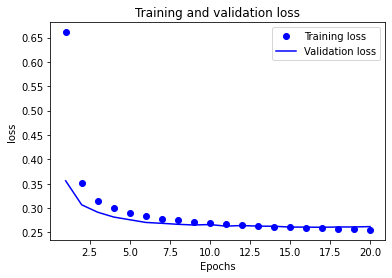

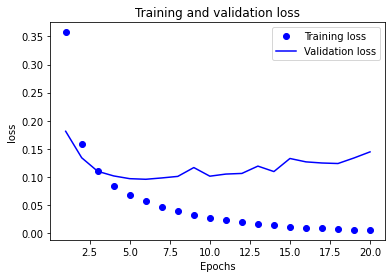

In [12]:
small_model = keras.Sequential(
    [layers.Dense(10, activation="softmax")]
)

big_model = keras.Sequential(
    [layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax")]
)

compile_kwargs = dict(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

small_model.compile(**compile_kwargs)
big_model.compile(**compile_kwargs)

train_args = [train_images, train_labels]
train_kwargs = dict(
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=0,
)

small_model_history = small_model.fit(*train_args, **train_kwargs)
big_model_history = big_model.fit(*train_args, **train_kwargs)

plot_history(small_model_history, "loss")
plot_history(big_model_history, "loss")

## Improving generalization

Once you have shown generalization power and ability to overfit, you focuss on maximizing generalization

### Regularizing your model

In [13]:
# helpers
from typing import List, Optional
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import Regularizer

def get_model_from_unit(units: List[int], regularizer: Optional[Regularizer]=None, dropout_r: Optional[float]=None):
    model_layers = []
    for u in units:
        model_layers.append(layers.Dense(u, activation="relu", kernel_regularizer=regularizer))
        if dropout_r is not None:
            model_layers.append(layers.Dropout(dropout_r))
        
    model_layers.append(layers.Dense(1, activation="sigmoid"))

    model = keras.Sequential(model_layers)
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["accuracy"],
        )

    return model

def fit_model(train_data, train_labels, model):
    history = model.fit(
        train_data, train_labels,
        epochs=20,
        batch_size=512,
        validation_split=.4,
        verbose=0,
    )

    return history

In [14]:
from tensorflow.keras.datasets import  imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10_000)

def vectorize_sequences(sequences, dimension=10_000):
    results = np.zeros((len(sequences), dimension))
    for i, seq in enumerate(sequences):
        results[i, seq] = 1.
    return results

train_data = vectorize_sequences(train_data)

#### Reducing network size

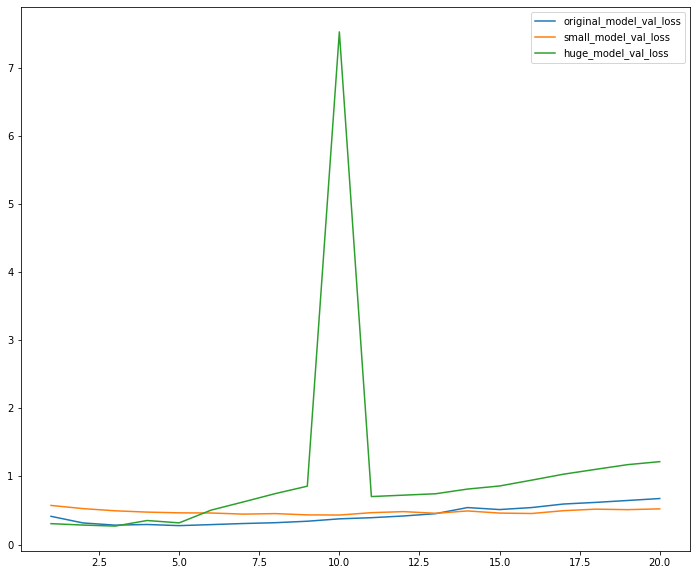

In [15]:
original_model_history = fit_model(train_data, train_labels, model=get_model_from_unit([16, 16]))
small_model_history = fit_model(train_data, train_labels, model=get_model_from_unit([4, 4]))
huge_model_history = fit_model(train_data, train_labels, model=get_model_from_unit([512, 512]))

plt.figure(figsize=(12,10))
epochs = range(1, 21)
plt.plot(epochs, original_model_history.history["val_loss"], label="original_model_val_loss")
plt.plot(epochs, small_model_history.history["val_loss"], label="small_model_val_loss")
plt.plot(epochs, huge_model_history.history["val_loss"], label="huge_model_val_loss")
plt.legend()
plt.show()


#### Weight regularization

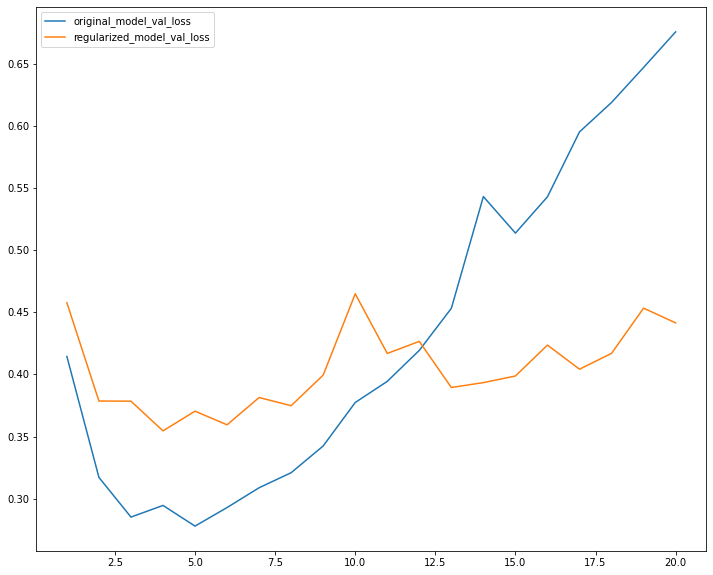

In [16]:
regularized_model_history = fit_model(train_data, train_labels, model=get_model_from_unit([16, 16], regularizer=regularizers.l2(0.002)))

plt.figure(figsize=(12,10))
epochs = range(1, 21)
plt.plot(epochs, original_model_history.history["val_loss"], label="original_model_val_loss")
plt.plot(epochs, regularized_model_history.history["val_loss"], label="regularized_model_val_loss")

plt.legend()
plt.show()


#### Dropout

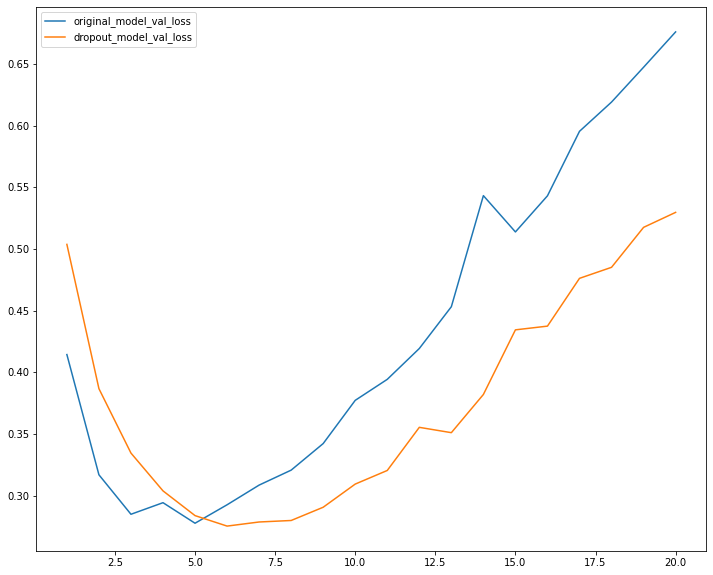

In [17]:
dropout_model_history = fit_model(train_data, train_labels, model=get_model_from_unit([16, 16], dropout_r=.5))

plt.figure(figsize=(12,10))
epochs = range(1, 21)
plt.plot(epochs, original_model_history.history["val_loss"], label="original_model_val_loss")
plt.plot(epochs, dropout_model_history.history["val_loss"], label="dropout_model_val_loss")

plt.legend()
plt.show()